# Topic Modeling on My Personal Emails

This notebook performs topic modeling on ~5000 emails that was extracted from one of my personal Gmail account. Since I have been using this email account for registration on a wide variety of websites, this account contains a large amount of promotions and advertisements. Besides, the account also contains a considerable amount of personal emails. I have been quite at a loss about how to classify these emails as a human being because of lots of overlap between these emails, so I was curious what a topic model would help me sort this out!

I choose to use two different implementations (Gensim and MALLET) of the Latent Dirichlet Allocation (LDA) algorithm on the body text of these emails in this short study. But before applying the LDA algorithm, one needs to carefully engineer the texts as a lot of email bodies are poorly formatted. Furthermore, after building a topic model, I would look into the topics and see if any insights can be drawn from the results.

Here is a summary of notebook:
- Text pre-processing I: Hyperlinks, stop words, punctuations, tokenization and lemmatization
- Text pre-processing II: Text cleaning, create bag of words representations
- Topic modeling with LDA
- Tuning the number of topics by optimizing the coherence
- Analyze and visualize the topics with pyLDAvis
- An LSA model (TF-IDF + SVD) for comparison

In [141]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
import spacy # Lemmatizer

import textwrap

### Text Pre-processing I: Remove hyperlinks, punctuations and stop words, Tokenize, Lemmatize

First perform some standard procedures for text pre-processing. There are a variety of tools for this job. Here is a summary:
- Remove punctuations and stop words using the *NLTK* library.
- Remove hyperlinks, which are often prevalent in the email body and could have some unwanted effects on tokenization.
- Tokenize with the simple_preprocess function from the GenSim library
- Lemmatizer: From the *spacy* library.

The following snippet of code defines some of the procedures:

In [80]:
class SpacyLemmatizer():
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        self.postags = ["NOUN", "VERB", "ADJ", "ADV"]
    def lemmatize(self, words):
        doc = self.nlp(' '.join(words))
        return ' '.join([t.lemma_ for t in doc if t.pos_ in self.postags])

def rm_punc_from_word(word):
    return ''.join([c for c in word if c not in string.punctuation])

stopwords_eng = stopwords.words('english')
stopwords_eng.extend(['from','subject','email'])
stopwords_nopunc = set(map(rm_punc_from_word, stopwords.words('english')))
stemmer = SnowballStemmer('english')

def clean_text(txt, lemmatize=False, stemming=False):
    '''
    Pre-process on the raw text: remove spurious features, remove punctuations and stop words, perform stemming.
    '''
    # Need to remove puntuation chars
    # txt.split() get things like 'food.\\n\\nI'
    # words = txt[2:-1].replace('\\n',' ') # txt = "b'...'"
    txt = txt.lower()
    words = txt.replace('\\n',' ') # txt = "b'...'"
    words = re.sub(r"https\S+", '', words)
    if(lemmatize):
        words = lemma.lemmatize(words)
    words = [c for c in words if c not in string.punctuation]
    words = ''.join(words)
    words = [wd for wd in words.split() if wd not in stopwords_nopunc]
    if(stemming):
        words = [stemmer.stem() for wd in words]
    return ' '.join(words)



Now run the pre-processing procedures step-by-step on the email dataset.

The lemmatization takes several minutes on the 5000 emails, so I keep the results (cleaned text) in a separate file to avoid repeating this procedure.

In [81]:
def clean_document():
    '''
    Convert raw email body text (inbox.json) into cleaned text (inboxClean.json).
    '''
    df = pd.read_json("inbox.json", orient='index')
    body = df['body'].apply(clean_text)
    body = body.apply(simple_preprocess)
    lemma = SpacyLemmatizer()
    # lemma = WordNetLemmatizer()
    body = body.apply(lemma.lemmatize) # A bit slow

    df['body'] = body
    df.to_json('inboxClean.json', orient='records', lines=True)    



In [11]:
df = pd.read_json('inboxClean.json', orient='records', lines=True)

In [15]:
df.loc[120:125]

,subject,sender,labels,body
120,Your qMenu order #703 from Oriental Taste (Nor...,support@qmenu360.com,"CATEGORY_UPDATES, INBOX",qmenu order qmenu detail thank order oriental ...
121,Culture To Do from Your Couch!,New England Public Media <vcerillo@nepr.net>,"CATEGORY_PROMOTIONS, INBOX",guide nepm thing enjoy home many live performa...
122,Thank you to our loyal fans from the SSO,Springfield Symphony Orchestra <info@springfie...,"CATEGORY_PROMOTIONS, INBOX",dear sso friend support advocacy faithful stew...
123,Supplies for MRO Professionals,"""Amazon.com"" <store-news@amazon.com>","CATEGORY_PROMOTIONS, INBOX",amazoncom shop business find discount wide ass...
124,Brand New HIFIMAN Headphones And More Back In ...,Audio46 <sales@audio46.com>,"CATEGORY_PROMOTIONS, INBOX",email send htmlonly view visit make sure keep ...
125,Get The Most From Your Gear With Top Accessori...,Adorama <info@shop.adorama.com>,"CATEGORY_PROMOTIONS, INBOX",first grab august new canon rebate right time ...


### Text Pre-processing II. Filter out Gibberish Words, Create Bag of Words Representations

Now, the cleaned email corpus has a total of ~ 1 M different tokens. However, most of these tokens are fragments of nonsenses from the html scripts that are not filtered out. Therefore, I want to select only the tokens that overlaps with the common English corpus. In addition, I included tokens that often appear in online text, e.g., the word "Google", that is not found in the NLTK english corpus.

After filtering out meaningless tokens, we are left with 13,000+ unique tokens from all across my emails.

In [7]:
nltk_words = set(nltk.corpus.words.words())
web_words = set(nltk.corpus.webtext.words('firefox.txt'))

body = df['body']
tokens = body.apply(lambda x: x.split())
tokens = tokens.apply(
    lambda x :
    list(filter(lambda y: y in nltk_words or y in web_words, x))
    )
# Bi-Gram is not very useful here
# bigram = gensim.models.Phrases(tokens, min_count=5, threshold=100)
# phraser = gensim.models.phrases.Phraser(bigram)
# tokens = tokens.apply(lambda x: phraser[x])




Number of tokens: 13582


Next, I create a dictionary that maps between the tokens and integer indices, id2word, and a bag of words representation for each document, corpus based on the dictionary. Both of these are needed for topic modeling with the GenSim.

In [ ]:
id2word = corpora.Dictionary(tokens, prune_at=20000)
print("Number of tokens: {}".format(len(id2word.values())))
corpus = [id2word.doc2bow(token) for token in tokens]

from collections import Counter
wordcnt = Counter()
for c in corpus:
    wordcnt.update(dict(c))

wordcnt = pd.DataFrame.from_dict(wordcnt, orient='index', columns=['count'])
wordcnt.index = wordcnt.index.map(id2word)
wordcnt.sort_values(by='count', ascending=False, inplace=True)

In [9]:
wordcnt.head(5)

,count
email,14093
bank,5936
account,5236
service,5098
new,4717


### Topic Modeling with Latent Dirichlet Allocation

Gensim library provides a LDA model by itself as well as an integration of the model from the MALLET package. 

The MALLET model consistently gets a higher coherence score on this dataset.

In [56]:
# wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
def LDAMallet(topics=10):
    lda_mallet = gensim.models.wrappers.LdaMallet("./mallet-2.0.8/bin/mallet", corpus=corpus, num_topics=topics, id2word=id2word, iterations=400)
    lda_coherence = CoherenceModel(model=lda_mallet, texts=tokens, dictionary=id2word, coherence='c_v')
    coherence = lda_coherence.get_coherence()
    return lda_mallet, coherence


In [82]:
scores = []
list_n_topics = [5, 8, 10, 15, 20, 30, 50]

A parameter search on the number of topics that maximize the coherence score.

In [ ]:
#list_n_topics = [5, 8, 10, 15, 20, 30, 50]
for n_topics in list_n_topics:
    coherence_score = LDAMallet(topics=n_topics)
    print("coherence: ", coherence_score)
    scores.append(coherence_score)

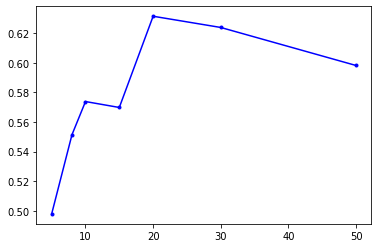

In [55]:
# scores_backup = \
# [0.4980102394170232,\
#  0.551385885362645,\
#  0.5737856225727729,\
#  0.5697916592029063,\
#  0.6313160920612332,\
#  0.6237441872547935,\
#  0.5981091793603894]
import matplotlib.pyplot as plt
plt.plot(list_n_topics, scores_backup, "b.-")

The MALLET LDA model has the best coherence score with ~ 20 topics. I trained a model with 20 topics and transform it for visualization using pyLDAvis. 

In [85]:
lda_mallet, _ = LDAMallet(20)
mallet_lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

In [169]:
def print_topics(lda_model):
    for topic in lda_model.print_topics():
        print("Topic {}:\n----------------".format(topic[0]))
        print(', '.join(topic[1].split('"')[1::2]))
        print()
        
df_topics = {}
for topic in lda_mallet.print_topics():
    topicstr = ', '.join(topic[1].split('"')[1::2])
    df_topics[topic[0]] = topicstr
df_topics = pd.DataFrame.from_dict(df_topics, orient='index', columns=['keywords'])

Take a look at the topics and the keywords associated with them. The keywords are ranked by their weights.

In [170]:
df_topics

,keywords
0,"payment, account, bill, service, property, con..."
1,"email, address, view, information, account, pr..."
2,"travel, book, find, include, time, flight, cit..."
3,"user, dear, regard, research, town, job, note,..."
4,"learn, watch, radio, listen, university, publi..."
5,"read, question, answer, group, good, thing, vi..."
6,"financial, market, investment, security, accou..."
7,"credit, email, view, send, card, karma, free, ..."
8,"price, member, regular, deal, prime, package, ..."
9,"bank, card, mobile, credit, reward, email, cas..."


It actually works reasonable well. As the keywords suggest, most of my emails are promotions or advertizements of different types. There are some overlaps of keywords among different topics. Nevertheless, A few topics are relatively easy to interpret, for example:
- \#11 is about music concert information, tickets and receipts
- \#2 is travel related
- \#3 is likely email exchanges with my friends as we use more personal greetings such as 'regards', 'dear'
- \#1 is about bills and payments
- \#6, \#7, \#9 is about my credit cards
- \#12 is about general banking services 
- \#18 is about insurance 
- \#19 has keywords like 'fontsize', 'px'. They come from a few companies that use a unique set of formatting that is not filtered out.

Example of using the Gensim LDA model. The coherence is about 0.5 at 10 ~ 40 topics, comparing to 0.6 from the MALLET model.

In [35]:
# The GenSim LDA Model
lda_params = {'corpus':corpus,
              'id2word':id2word,
              'num_topics':40,
              'random_state':42,
              'chunksize':200,
              'passes':10,
              'iterations':500,
              'alpha':'auto',
              'per_word_topics':False}

lda = gensim.models.ldamodel.LdaModel(**lda_params)
print("Perplexity: ", lda.log_perplexity(corpus))
# lda.show_topics()

lda_coherence = CoherenceModel(model=lda, texts=tokens, dictionary=id2word, coherence='c_v')
print("Coherence: ", lda_coherence.get_coherence())


Perplexity:  -11.223871802715838
Coherence:  0.47707025636050615


### Visualize Topics with pyLDAvis

pyLDAvis is a quite useful tool for interactively viewing the topics. The topic numbers in the left panel are ranked by their prevalence in the corpus and are therefore different from the order listed above. Notably, the cluster of topics in the upper left corner are more or less personal and the topics in the upper right corner are more related to finances, payment, etc.

In [37]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [86]:
#vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
vis = pyLDAvis.gensim.prepare(mallet_lda_model, corpus, id2word)

/home/shuiyao/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/shuiyao/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/shuiyao/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


In [87]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.292396  0.091559       1        1  6.903739
17    -0.230180  0.083016       2        1  6.735520
13    -0.048321 -0.298610       3        1  6.254275
11    -0.173919  0.070346       4        1  6.176665
19    -0.046927 -0.249887       5        1  5.953487
6     -0.024959 -0.043417       6        1  5.789351
18    -0.012371 -0.090371       7        1  5.217790
9      0.212523 -0.012680       8        1  5.199714
0      0.128141  0.022939       9        1  5.185284
4     -0.214872  0.053957      10        1  4.815288
5     -0.152272  0.133361      11        1  4.803140
15    -0.209732  0.095538      12        1  4.792436
10     0.064079 -0.245789      13        1  4.518742
8      0.099965 -0.126999      14        1  4.339511
1      0.258234  0.133084      15        1  4.130775
2     -0.136423  0.032388      16        1  4.094711
14    -0.009601  0.012275      17        1  3.994191
16     0.176340  0.166156      18        1  3.962957
7      0.118286  0.061687      19        1  3.671909
3     -0.090387  0.111447      20        1  3.460516, topic_info=             Term          Freq         Total Category  logprob  loglift
81          email  14959.000000  14959.000000  Default  30.0000  30.0000
960          bank   5919.000000   5919.000000  Default  29.0000  29.0000
85      important   4092.000000   4092.000000  Default  28.0000  28.0000
4021           ge   3187.000000   3187.000000  Default  27.0000  27.0000
5684          rho   3068.000000   3068.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1943      morning    207.354868    387.697177  Topic20  -4.9048   2.7380
283          work    277.263081   1240.947986  Topic20  -4.6142   1.8651
256   performance    245.271187   1153.367954  Topic20  -4.7368   1.8157
324         start    253.565382   1578.822876  Topic20  -4.7036   1.5349
77         access    221.573488   1678.847841  Topic20  -4.8384   1.3386

[1734 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
2132       3  0.023517    aa
2132       5  0.112358    aa
2132       6  0.015678    aa
2132       7  0.658470    aa
2132       8  0.184215    aa
...      ...       ...   ...
10643     19  1.014716  yuan
9015       3  0.998921   yyy
4515       3  1.005164   zig
1923      12  1.001177   zoo
2562      10  0.999927  zoom

[3213 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 18, 14, 12, 20, 7, 19, 10, 1, 5, 6, 16, 11, 9, 2, 3, 15, 17, 8, 4])

Now we can use the trained model to make inference on any article. The two example below seem to have placed reasonable topic on them.

In [215]:
def show_topic_of_article_mallet(i, top_n_keywords=8):
    topics = np.array(mallet_lda_model.get_document_topics(corpus[i]))[:, 1]
    topic_id = np.argmax(topics)
    topwords = df_topics['keywords'][topic_id].split(',')[:top_n_keywords]
    print("Topic Keywords:  {}".format(', '.join(topwords)))
    print("Score:   {:5.3f}".format(np.max(topics)))
    print("================================================================")
    print("Subject: {}".format(df['subject'][i]))
    print("--------------------------------")
    print(textwrap.fill(df['body'][i], width=70))
    print()

show_topic_of_article_mallet(1142)
show_topic_of_article_mallet(1029)

Topic Keywords:  special,  river,  trip,  raft,  spring,  season,  june,  click
Score:   0.384
Subject: Last Chance for the Lowest Price on Epic Pass
--------------------------------
get pass september purchase epic pass september lock low price score
buddy ticket pass holder exclusive access mount snow early season
schedule opening date november december ve previously announce safety
well manage many people mountain season implement pass holder
reservation system reservation require pass holder get priority access
reservation system go live november be sure make reservation epic
coverage election december purchase september exclusive early season
access pass holder get mountain dec sell lift ticket dec early season
reservation book week advance view detail priority access core season
pass holder receive early opportunity reserve priority reservation day
core season dec april lift ticket go sale view detail epic coverage
pass come epic coverage provide refund associate certain personal

## Compare with Latent Semantic Analysis (LSA)

Here I build another topic model using LSA, which performs SVD over the document term matrix generated using the Term Frequency - Inverse Document Frequency (TF-IDF).

First define some help functions:

In [160]:
def show_feature_for_text(wordvec, wordfeat, row_index, topn=10):
    '''
    Usage: show_feature_for_text(wordvec, wordfeat, row_index)
    Purpose: Show a list of non-zero TF-IDF values for a document specified by row_index.
    '''
    row = wordvec.getrow(row_index)
    idx, val = row.indices, row.toarray()[0][row.indices]
    keyw = [wordfeat[i] for i in idx]
    data = pd.DataFrame({"keyword":keyw, "TfIdf":val})    
    data.sort_values(by="TfIdf", ascending=False, inplace=True)
    print(data.head(topn))

def show_subjects_with_keyword(keyword, df, wordvec, topn=5):
    rowidx = featmap.get(keyword)
    if(rowidx is None):
        print(keyword, "is not a valid keyword")
        return
    cols = wordvec.getcol(featmap[keyword])
    indices = cols.nonzero()[0]
    val = cols.toarray()[indices][:,0]
    subjects = []
    for i, idx in enumerate(indices):
        subjects.append((val[i], df['subject'][idx]))
        # subjects.append((val[i], df['sender'][idx]))        
    df_sub = pd.DataFrame(subjects, columns=['TfIdf', 'subject'])
    df_sub.sort_values(by='TfIdf', ascending=False, inplace=True)
    niter = min(df_sub.shape[0], topn)
    for i in range(niter):
        idx = df_sub.index[i]
        print("{:5.3f}  {}".format(df_sub['TfIdf'][idx], df_sub['subject'][idx]))
    print("\n{:d} emails contain keyword {}".format(df_sub.shape[0], keyword))

def view_topic_model_components(model, wordfeat, top_n_words=10):
    df_topics = {}
    for i, topic in enumerate(model.components_):
        topwords = np.array(wordfeat)[np.argsort(topic)[-top_n_words:][::-1]]
        weights = np.sort(topic)[-top_n_words:][::-1]
        df_topics[i] = ', '.join(topwords)
    df_topics = pd.DataFrame.from_dict(df_topics, orient='index', columns=['keywords'])
    return df_topics
        # print(weights)

def show_topic_of_article(i, model, wordfeat):
    topic_id = np.argmax(topics[i])
    embeddings = model.components_[topic_id]
    topwords = np.array(wordfeat)[np.argsort(embeddings)[-8:][::-1]]
    print("Topics:  {}".format(', '.join(topwords)))
    print("Score:   {:5.3f}".format(np.max(topics[i])))
    print("================================================================")
    print("Subject: {}".format(df['subject'][i]))
    print("--------------------------------")
    print(textwrap.fill(df['body'][i], width=70))


In [118]:
max_features=2000
max_df=0.8
min_df=1
tfidf = TfidfVectorizer(max_features=max_features,
                        max_df=max_df,
                        min_df=min_df)

In [119]:
body = tokens.apply(lambda x: ' '.join(x))
tfidfvec = tfidf.fit_transform(body)
tfidffeat = tfidf.get_feature_names()
featmap = {k:v for v,k in enumerate(tfidffeat)}

The following function returns the top 10 keywords in a document with the highest TF-IDF scores

In [138]:
show_feature_for_text(tfidfvec, tfidffeat, 12)

         keyword     TfIdf
20        career  0.457900
9        advisor  0.292505
2         actual  0.254300
3       automate  0.247229
14      interest  0.222842
13         error  0.218975
15           ave  0.218975
5        involve  0.216640
12           job  0.203969
19  notification  0.200744


The following function displays the subject of emails that are most relevant to any given keyword:

In [218]:
show_subjects_with_keyword('action', df, tfidfvec, topn=5)

0.317  Resolve 1 security issue found on your Google account
0.216  [GitHub] Your password was reset
0.199  Giving Tuesday Next Week!
0.197  You now have unlimited collaborators in private repositories
0.173  TAKE ACTION: Urge Congress to pass the RESTAURANTS Act

257 emails contain keyword action


In [145]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=400, random_state=42)

topics = svd.fit_transform(tfidfvec)

topics.shape

(5751, 20)

The 'topics' assign weights of the 20 topics for each article

Now take a look at the topics found using LSA:

In [219]:
df_topics_svd = view_topic_model_components(svd, tfidffeat, top_n_words=10)
df_topics_svd

,keywords
0,"bank, email, service, account, banking, online..."
1,"bank, banking, statement, lender, corporation,..."
2,"payment, property, bill, intellectual, account..."
3,"rho, ge, baw, fn, offer, delivery, order, paym..."
4,"credit, karma, order, apple, inc, score, price..."
5,"statement, banking, mobile, card, number, acco..."
6,"karma, credit, score, cheer, group, edit, chur..."
7,"church, order, group, growth, ministry, ferry,..."
8,"apple, bank, bill, app, purchase, enterprise, ..."
9,"enterprise, rental, vehicle, car, deal, price,..."


Compared the LDA results, the LSA results seem more mixed up.